In [2]:
#RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/cs109.css"
).text
HTML(styles)

In [3]:
import re
import requests
from time import sleep
from bs4 import BeautifulSoup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score
from sklearn.utils import resample
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score

%matplotlib inline

import seaborn as sns
sns.set(style='whitegrid')
pd.set_option('display.width', 1500)

## Data Set

In [4]:
# Load data
df = pd.read_csv('data/df_fifa.csv')

In [5]:
df.head()

,sofifa_id,short_name,age,dob,height_cm,weight_kg,nationality,club,overall,value_eur,...,ab_mentality_composure,ab_defending_marking,ab_defending_standing_tackle,ab_defending_sliding_tackle,ab_goalkeeping_diving,ab_goalkeeping_handling,ab_goalkeeping_kicking,ab_goalkeeping_positioning,ab_goalkeeping_reflexes,d_foot_left
0,158023,L. Messi,27,1987-06-24,169,67,Argentina,FC Barcelona,93,0,...,NaN,25,21,20,6,11,15,14,8,1
1,20801,Cristiano Ronaldo,29,1985-02-05,185,80,Portugal,Real Madrid,92,0,...,NaN,22,31,23,7,11,15,14,11,0
2,9014,A. Robben,30,1984-01-23,180,80,Netherlands,FC Bayern München,90,0,...,NaN,29,26,26,10,8,11,5,15,1
3,41236,Z. Ibrahimović,32,1981-10-03,195,95,Sweden,Paris Saint-Germain,90,0,...,NaN,25,41,27,13,15,10,9,12,0
4,167495,M. Neuer,28,1986-03-27,193,92,Germany,FC Bayern München,90,0,...,NaN,25,25,25,87,85,92,90,86,0


In [17]:
list(df.columns)

['sofifa_id',
 'short_name',
 'age',
 'dob',
 'height_cm',
 'weight_kg',
 'nationality',
 'club',
 'overall',
 'value_eur',
 'wage_eur',
 'preferred_foot',
 'international_reputation',
 'weak_foot',
 'work_rate',
 'body_type',
 'release_clause_eur',
 'team_position',
 'team_jersey_number',
 'loaned_from',
 'joined',
 'contract_valid_until',
 'year',
 'league_name',
 'd_trait_Avoids_Using_Weaker_Foot',
 'd_trait_Beat_Offside_Trap',
 'd_trait_Finesse_Shot',
 'd_trait_Long_Throw-in',
 'd_trait_Through_Ball',
 'd_trait_Takes_Finesse_Free_Kicks',
 'd_trait_Power_Header',
 'd_trait_Injury_Free',
 'd_trait_Crowd_Favourite',
 'd_trait_1-on-1_Rush',
 'd_trait_Flair',
 'd_trait_Outside_Foot_Shot',
 'd_trait_Inflexible',
 'd_trait_Giant_Throw-in',
 'd_trait_Cautious_With_Crosses',
 'd_trait_Saves_with_Feet',
 'd_trait_Puncher',
 'd_trait_Rushes_Out_Of_Goal',
 'd_trait_Skilled_Dribbling',
 'd_trait_Backs_Into_Player',
 'd_trait_Second_Wind',
 'd_trait_Set_Play_Specialist',
 'd_trait_Leadership',
 

In [76]:
df['main_position'].describe()

count     101083
unique        15
top           CB
freq       17105
Name: main_position, dtype: object

## EDA

Filtering by year 2020

In [51]:
df_20 = df[df['year'] != 2020]

Height Distribution

[Text(0.5, 0, 'Height'),
 Text(0.5, 1.0, 'Distribution of height (in cm), 2015 - 2020')]

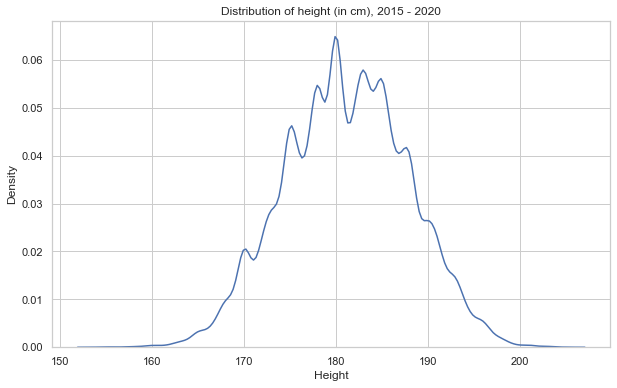

In [58]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.kdeplot(df_20.height_cm, ax=ax)
ax.set(xlabel='Height', title='Distribution of height (in cm), 2015 - 2020')

Age Distribution

[Text(0.5, 0, 'Age'), Text(0.5, 1.0, 'Distribution of age, 2015 - 2020')]

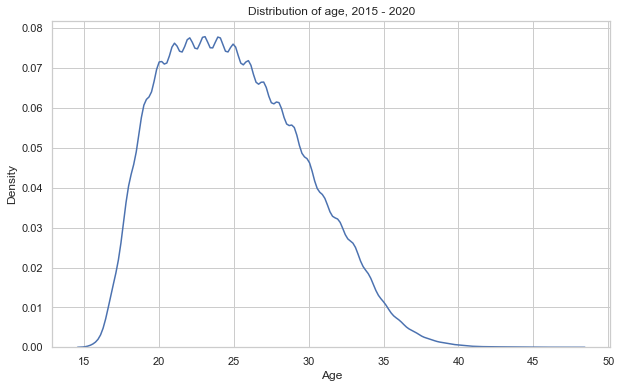

In [57]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
sns.kdeplot(df_20.age, ax=ax)
ax.set(xlabel='Age', title='Distribution of age, 2015 - 2020')

Text(0, 0.5, 'Wage')

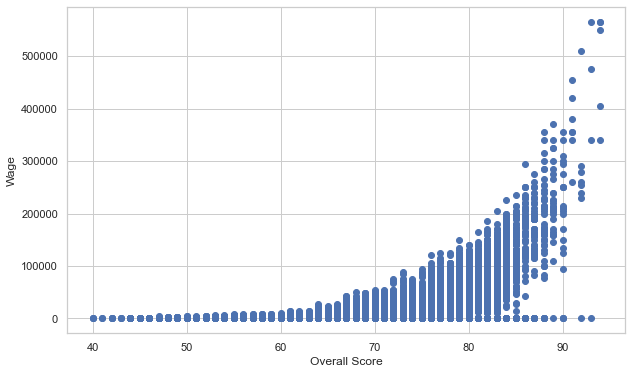

In [46]:
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.scatter(df_20.overall,df_20.wage_eur)
ax.set_xlabel("Overall Score")
ax.set_ylabel("Wage")


Text(0, 0.5, 'Wage')

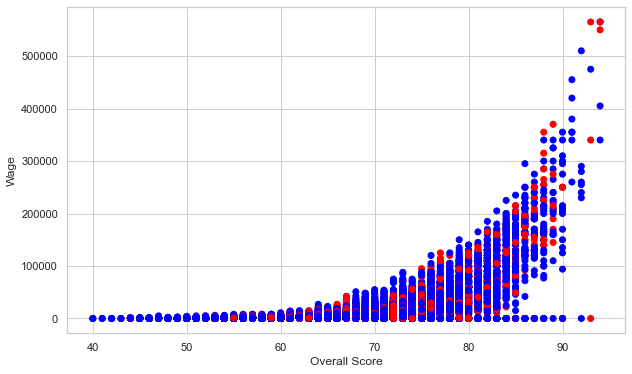

In [66]:
colors = {'Left':'red', 'Right':'blue'}
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.scatter(df_20['overall'],df_20['wage_eur'], c = df_20['preferred_foot'].map(colors))
ax.set_xlabel("Overall Score")
ax.set_ylabel("Wage")

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


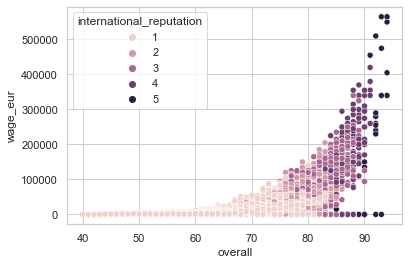

In [78]:
sns.scatterplot('overall', 'wage_eur', data=df_20, hue='international_reputation')

Text(0, 0.5, 'Wage')

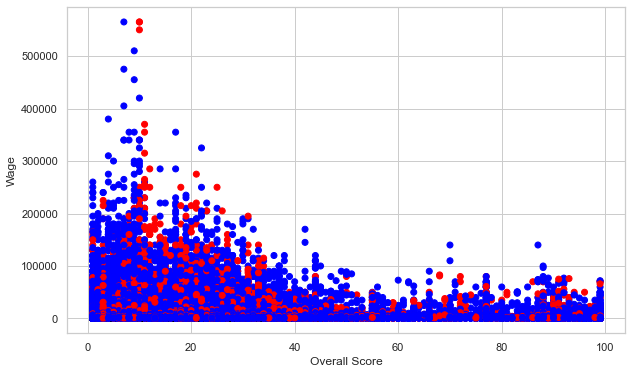

In [77]:
colors = {'Left':'red', 'Right':'blue'}
fig, ax = plt.subplots(1, 1, figsize = (10, 6))
ax.scatter(df_20['team_jersey_number'],df_20['wage_eur'], c = df_20['preferred_foot'].map(colors))
ax.set_xlabel("Overall Score")
ax.set_ylabel("Wage")

In [80]:
club_group = df_20.groupby(by = ['club']).mean()

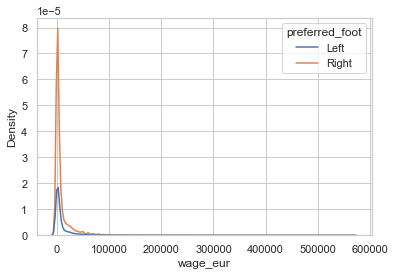

In [83]:
sns.kdeplot(data=df_20, x=df_20['wage_eur'], hue='preferred_foot', legend=True)



In [85]:
foot_group = df_20.groupby(by = ['preferred_foot']).mean()

In [96]:
foot_group[['overall', 'wage_eur']].describe()

,overall,wage_eur
count,2.000000,2.000000
mean,65.886808,9163.040390
std,0.443684,341.562448
min,65.573076,8921.519266
25%,65.729942,9042.279828
50%,65.886808,9163.040390
75%,66.043674,9283.800951
max,66.200540,9404.561513


([<matplotlib.axis.XTick at 0x7f9b86f20f10>,
 [Text(0, 0, 'Left'), Text(0, 0, 'Right')])

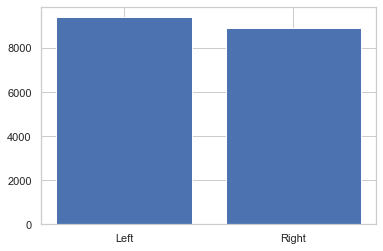

In [92]:
plt.bar(np.arange(2),foot_group['wage_eur'])
plt.xticks(np.arange(2), ('Left', 'Right'))